In [52]:
import numpy as np
import matplotlib.pyplot as plt
from modules.utility import generate_player_beliefs

# Example usage
P1_beliefs, P2_beliefs = generate_player_beliefs()

# Define the rewards and payoffs
r1, r2 = 3, 3  # Reward for mutual cooperation
t1, t2 = 5, 5  # Temptation payoff
p1, p2 = 0, 0  # Punishment payoff
s1, s2 = 1, 1  # Sucker's payoff
gamma = 0.9,.6,.3,.2,.1    # Discount rate

# Define the rewards matrix
rewards_matrix = np.array([
    [r1, r2],  # Payoffs for when both cooperate
    [t1, p2],  # Payoffs for when one defects and the other cooperates
    [p1, t2],  # Payoffs for when one defects and the other cooperates
    [s1, s2]   # Payoffs for when both defect
])

print("Player 1 Beliefs:", P1_beliefs)
print("Player 2 Beliefs:", P2_beliefs)

Player 1 Beliefs: {'CC': 0.65, 'CB': 0.49, 'BC': 0.06, 'BB': 0.64}
Player 2 Beliefs: {'CC': 0.82, 'CB': 0.66, 'BC': 0.71, 'BB': 0.0}


[3, 5, 0, 1]
[3, 0, 5, 1]
tensor([[3.6885, 3.5191],
        [5.6132, 0.6363],
        [0.6132, 5.6363],
        [1.6885, 1.5191]], grad_fn=<MmBackward0>)
done testing
tensor([[3.7393, 3.7234],
        [5.7292, 0.7296],
        [0.7292, 5.7296],
        [1.7393, 1.7234]], grad_fn=<MmBackward0>)


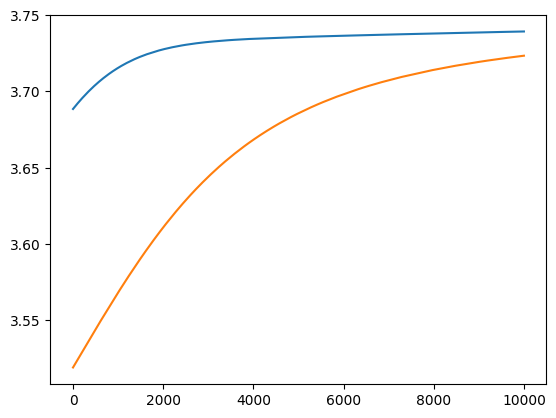

In [55]:
from modules.Player import Player
from modules.PlayerEnv import PlayerEnv
from torch import optim

pl1,pl2=Player(P1_beliefs,[r1,t1,p1,s1]),Player(P2_beliefs,[r2,p2,t2,s2])

# Define optimizers for each player
# Assuming that Player class has a method 'parameters()' that returns its parameters
optimizer_p1 = optim.SGD(pl1.parameters(), lr=0.001)
optimizer_p2 = optim.SGD(pl2.parameters(), lr=0.001)

env=PlayerEnv(pl1,pl2,.2)

print(env.play())

print("done testing")

# Training loop
num_epochs = 10000
plot=[[],[]] #plotting
for epoch in range(num_epochs):

    """
    The first agent adjusts its parameters attempting to maximize the objective
    """
    reward = env.play()
    plot[0].append(float(reward[0,0])) #plotting
    optimizer_p1.zero_grad()
    rp1 = reward[:, 0]
    loss_p1 = -rp1.sum()
    loss_p1.backward()
    optimizer_p1.step()
    
    """
    The second agent adjusts its parameters attempting to maximize the objective
    """
    reward = env.play()
    plot[1].append(float(reward[0,1])) #plotting
    optimizer_p2.zero_grad()
    rp2 = reward[:, 1]
    loss_p2 = -rp2.sum()
    loss_p2.backward()
    optimizer_p2.step()

    # Logging
    #if epoch % 10 == 0:
    #    print(f"Epoch {epoch}: pl1 reward = {rp1.sum().item()}, pl2 reward = {rp2.sum().item()}")

print(env.play())

plt.plot(plot[0], label="Player 1") #plotting
plt.plot(plot[1], label="Player 2") #plotting

[3, 5, 0, 1]
[3, 0, 5, 1]
tensor([[3.7468, 3.6251],
        [5.6938, 0.7010],
        [0.6938, 5.7010],
        [1.7468, 1.6251]], grad_fn=<MmBackward0>)


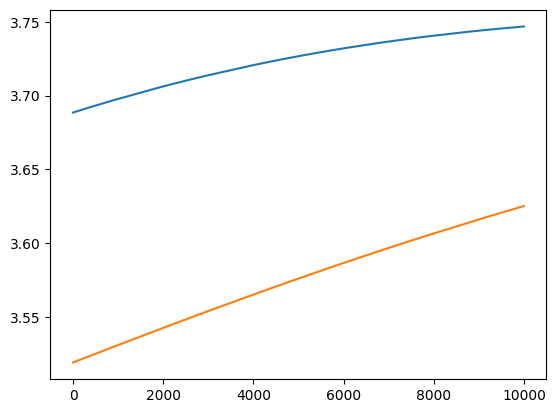

In [56]:
from CGDs import ACGD
lr = 0.0001

pl1=Player(P1_beliefs,[r1,t1,p1,s1])
pl2=Player(P2_beliefs,[r2,p2,t2,s2])
env=PlayerEnv(pl1,pl2,.2)
optimizer = ACGD(max_params=pl1.parameters(), min_params=pl2.parameters(), lr_max=lr, lr_min=lr)

# max_parems is maximizing the objective function while the min_params is trying to minimizing it. 
# BCGD(max_params=G.parameters(), min_params=D.parameters(), lr_max=lr, lr_min=lr, device=device)
# ACGD: Adaptive CGD;
plot=[[],[]] #plotting
for epoch in range(10000):
    """
    An aggregate is taken - the reward of the first player is added, the second player's is subtracted
    First player tries to maximize this
    Second player tries to minimize this
    """
    reward=env.play()
    plot[0].append(float(reward[0,0])) #plotting
    plot[1].append(float(reward[0,1])) #plotting
    pl1reward = reward[:, 0].sum()
    pl2reward = reward[:, 1].sum()
    reward = pl1reward - pl2reward
    optimizer.zero_grad()
    optimizer.step(loss=reward)

print(env.play())

plt.plot(plot[0], label="Player 1") #plotting
plt.plot(plot[1], label="Player 2") #plotting